<a href="https://colab.research.google.com/github/rithika928/US-Accidents-Analysis/blob/main/skillcraft_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK - 4**

Analyze traffic accident data to identify patterns related to road conditions, weather, and time of day. Visualize accident hotspots and contributing factors.

Saving US_Accidents_sample.csv to US_Accidents_sample (1).csv


/tmp/ipython-input-3018134584.py:11: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("US_Accidents_sample.csv", skiprows=19)


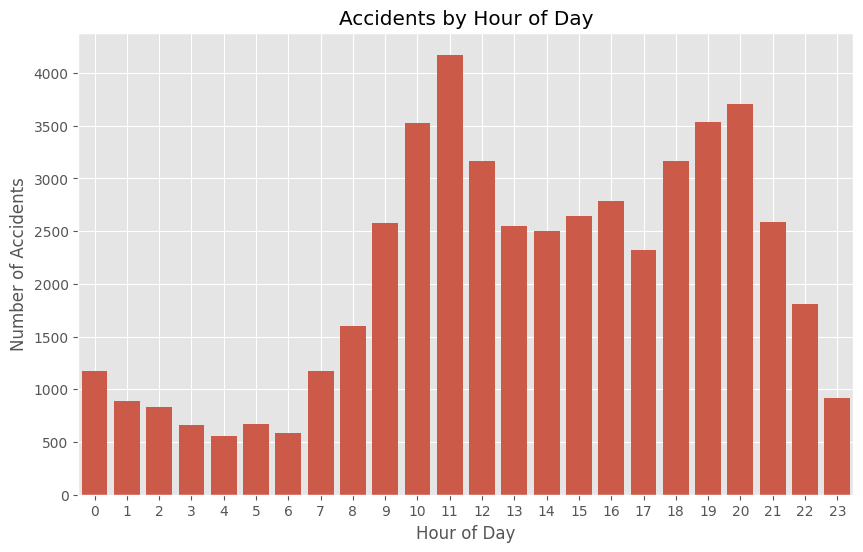

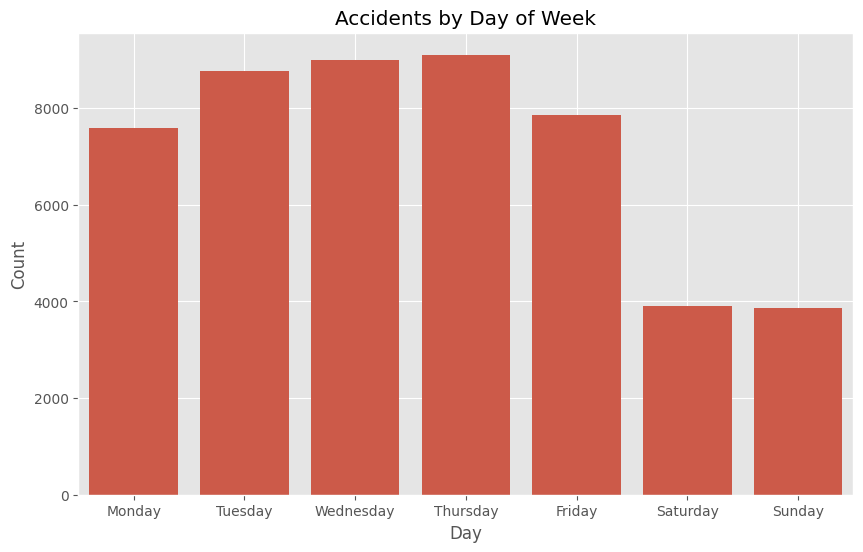

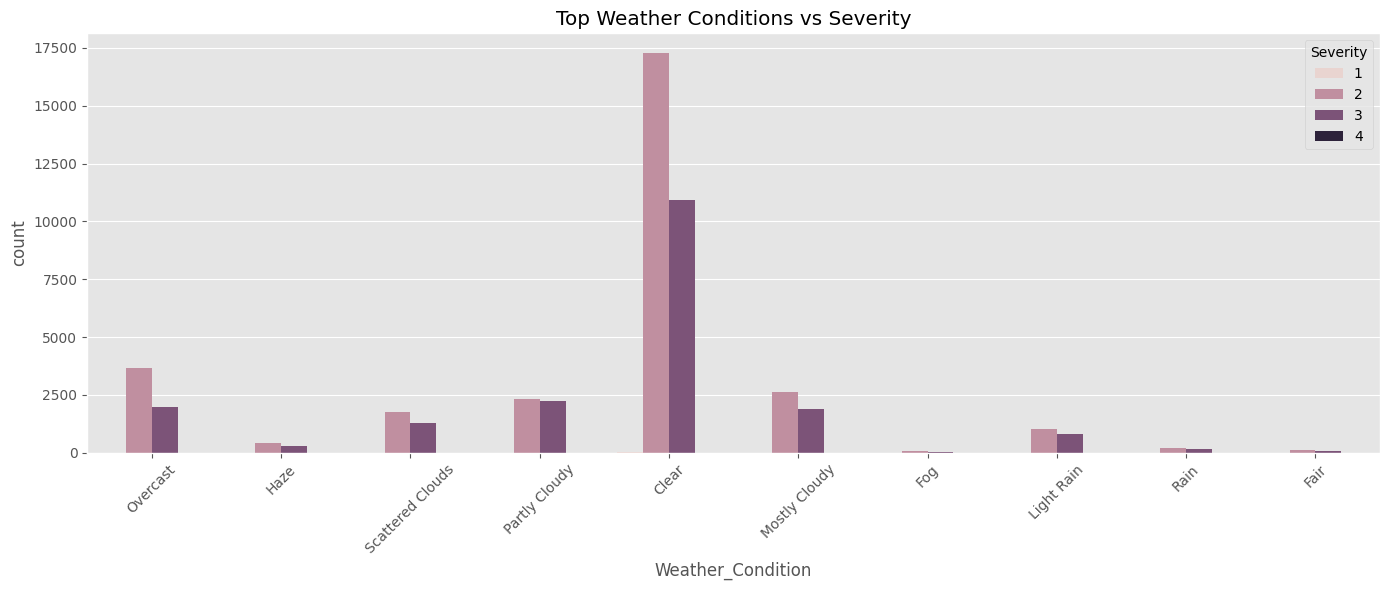

In [ ]:
# Upload the file (for Google Colab users)
from google.colab import files
uploaded = files.upload()

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your resampled dataset (with skipped rows if needed)
df = pd.read_csv("US_Accidents_sample.csv", skiprows=19)

# Optionally rename columns to meaningful names
df.columns = [
    'ID', 'Source', 'Severity', 'Start_Time', 'End_Time',
    'Start_Lat', 'Start_Lng', 'Street', 'Side',
    'Distance(mi)', 'Description', 'Number', 'City', 'County', 'State', 'Zipcode',
    'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)',
    'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump',
    'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
    'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
]

# Convert time column to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Create new time-based features
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.day_name()
df['Month'] = df['Start_Time'].dt.month

# Accidents by Hour
plt.figure(figsize=(10,6))
sns.countplot(x='Hour', data=df)
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.show()

# Accidents by Day of Week
plt.figure(figsize=(10,6))
sns.countplot(x='DayOfWeek', data=df,
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Accidents by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Top 10 Weather Conditions with Severity breakdown
plt.figure(figsize=(14,6))
top_weather = df['Weather_Condition'].value_counts().head(10).index
sns.countplot(x='Weather_Condition', data=df[df['Weather_Condition'].isin(top_weather)],
              hue='Severity')
plt.title('Top Weather Conditions vs Severity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


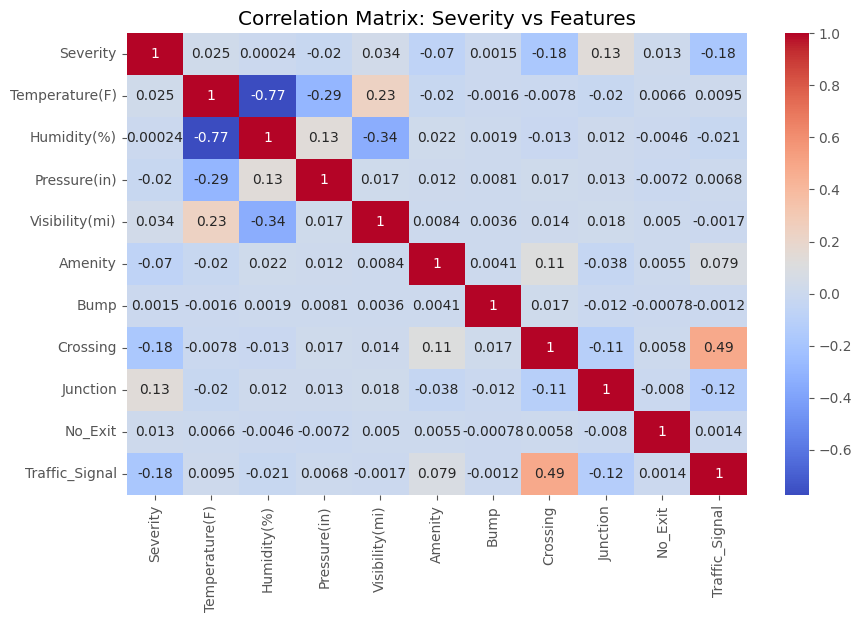

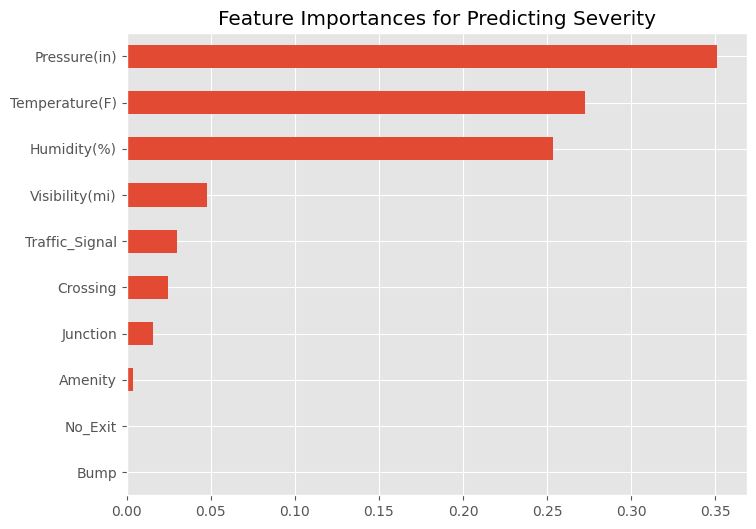

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.67      0.72      0.70      7379
           3       0.53      0.47      0.50      4919
           4       0.00      0.00      0.00         4

    accuracy                           0.62     12316
   macro avg       0.30      0.30      0.30     12316
weighted avg       0.62      0.62      0.62     12316



In [ ]:
# Import libraries for mapping and analysis
import folium
from folium.plugins import HeatMap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- 1. Accident Hotspot Heatmap ---
# Drop rows with missing coordinates
df_map = df[['Start_Lat', 'Start_Lng']].dropna().sample(1000)

# Create a folium map centered in the US
heat_map = folium.Map(location=[39.5, -98.35], zoom_start=4)
HeatMap(data=df_map[['Start_Lat', 'Start_Lng']].values, radius=7).add_to(heat_map)

# Save the map to view later
heat_map.save("accident_hotspots.html")

# --- 2. Correlation Heatmap for Severity Factors ---
# Select numerical and boolean columns for correlation analysis
corr_cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
             'Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Traffic_Signal']

# Convert boolean to numeric
df_corr = df[corr_cols].copy()
for col in corr_cols:
    if df_corr[col].dtype == 'bool':
        df_corr[col] = df_corr[col].astype(int)

# Plot the correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: Severity vs Features")
plt.show()

# --- 3. Feature Importance with Random Forest ---
# Prepare feature and target
target = 'Severity'
features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
            'Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Traffic_Signal']

X = df[features].copy()
y = df[target]

# Drop NA and convert bool to int
X = X.dropna()
y = y.loc[X.index]
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importances for Predicting Severity")
plt.grid(True)
plt.show()

# Classification report
preds = model.predict(X_test)
print(classification_report(y_test, preds))